In [19]:
# import required libraries
import pandas as pd
import numpy as np
import tensorflow
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, Dropout, MaxPool2D
import matplotlib.pyplot as plt

In [2]:
# some constant variables
image_size = 256
batch_size = 32

In [14]:
# declare dataset while importing path
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r'C:\Users\Arfan Shah\Train',
    shuffle = True,
    image_size = (image_size, image_size),
    batch_size = batch_size
)

Found 5702 files belonging to 3 classes.


In [15]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [16]:
# find length of dataset
len(dataset)

179

(32, 256, 256, 3)
[0 1 2 2 0 0 0 0 1 1 1 2 2 2 2 1 2 0 0 2 0 1 1 2 2 2 1 0 2 0 1 1]
0


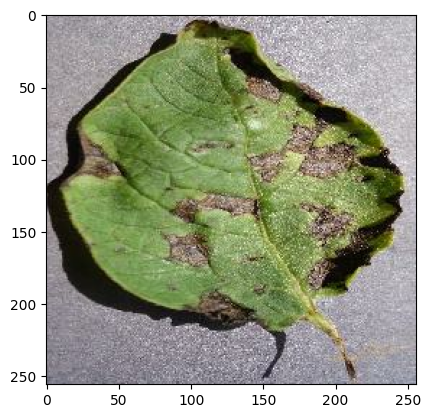

In [31]:
# lets find out images in one batch
for image_batch, label_batch in dataset.take(1):
   
    print(image_batch.shape)
    print(label_batch.numpy())
    plt.imshow(image_batch[0].numpy().astype('uint8'))
    print(label_batch[0].numpy())